Correlation Analysis

In [1]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Import rasterio
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pathlib
import numpy as np
import seaborn as sns

In [2]:
def create_combined_geodataframe(ndvi_path, ndbi_path, lst_path, step_size=10):
    """
    Create a combined GeoDataFrame from NDVI, NDBI, and LST raster files.
    
    Parameters:
    -----------
    ndvi_path : str
        Path to the NDVI raster file
    ndbi_path : str
        Path to the NDBI raster file
    lst_path : str
        Path to the LST raster file
    step_size : int
        Sampling interval for points (default=10)
    
    Returns:
    --------
    GeoDataFrame with NDVI, NDBI, LST values and point geometries
    """
    # Initialize lists to store data
    points = []
    ndvi_values = []
    ndbi_values = []
    lst_values = []
    
    # Read all three raster files
    with rasterio.open(ndvi_path) as ndvi_src, \
         rasterio.open(ndbi_path) as ndbi_src, \
         rasterio.open(lst_path) as lst_src:
        
        # Read raster data
        ndvi_data = ndvi_src.read(1)
        ndbi_data = ndbi_src.read(1)
        lst_data = lst_src.read(1)
        
        # Use transform from first raster (assuming all are aligned)
        transform = ndvi_src.transform
        rows, cols = ndvi_data.shape
        
        # Loop through the raster data
        for row in range(0, rows, step_size):
            for col in range(0, cols, step_size):
                # Get values from all three rasters
                ndvi_val = ndvi_data[row, col]
                ndbi_val = ndbi_data[row, col]
                lst_val = lst_data[row, col]
                
                # Check if any value is valid (not NaN or NoData)
                if not (np.isnan(ndvi_val) or np.isnan(ndbi_val) or np.isnan(lst_val)):
                    # Get the (x, y) coordinates for the cell
                    x, y = rasterio.transform.xy(transform, row, col)
                    
                    # Append values and point geometry
                    points.append(Point(x, y))
                    ndvi_values.append(ndvi_val)
                    ndbi_values.append(ndbi_val)
                    lst_values.append(lst_val)
    
    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame({
        'NDVI': ndvi_values,
        'NDBI': ndbi_values,
        'LST': lst_values,
        'geometry': points
    })
    
    return gdf

# Example usage:
if __name__ == "__main__":
    # Replace these paths with your actual file paths
    ndvi_file = 'data/2024_ndvi.tif'
    ndbi_file = 'data/2024_ndbi.tif'
    lst_file = 'data/2024_lst.tif'
    
    # Create the combined GeoDataFrame
    combined_gdf = create_combined_geodataframe(ndvi_file, ndbi_file, lst_file)
    
    # Display the first few rows
    print(combined_gdf.head())
    
    # Save to file if needed
    combined_gdf.to_file('data/pankow_indices.gpkg', driver='GPKG')

       NDVI      NDBI        LST                   geometry
0  0.515225 -0.122205  30.398345  POINT (13.46552 52.67420)
1  0.628274 -0.173878  30.895261  POINT (13.46642 52.67420)
2  0.672125 -0.238656  29.825572  POINT (13.46732 52.67420)
3  0.665138 -0.232976  30.531908  POINT (13.46822 52.67420)
4  0.662709 -0.184928  30.975888  POINT (13.46911 52.67420)


In [3]:
combined_gdf['NDBI'].describe()

count    146092.000000
mean         -0.233627
std           0.144774
min          -0.744512
25%          -0.356017
50%          -0.236288
75%          -0.131340
max           0.515059
Name: NDBI, dtype: float64

In [4]:
corr_matrix = combined_gdf[["NDVI","NDBI","LST"]].corr()

corr_matrix

,NDVI,NDBI,LST
NDVI,1.000000,-0.665880,-0.424853
NDBI,-0.665880,1.000000,0.678414
LST,-0.424853,0.678414,1.000000


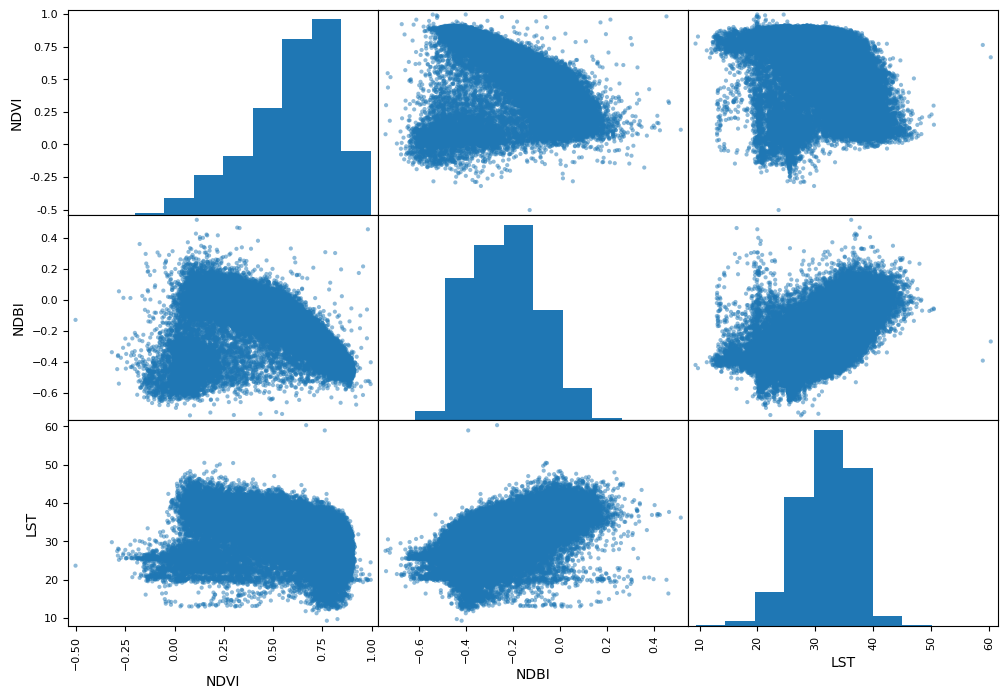

In [5]:
from pandas.plotting import scatter_matrix

attributes = ["NDVI","NDBI","LST"]
              
_ = scatter_matrix(combined_gdf[attributes], figsize=(12, 8))

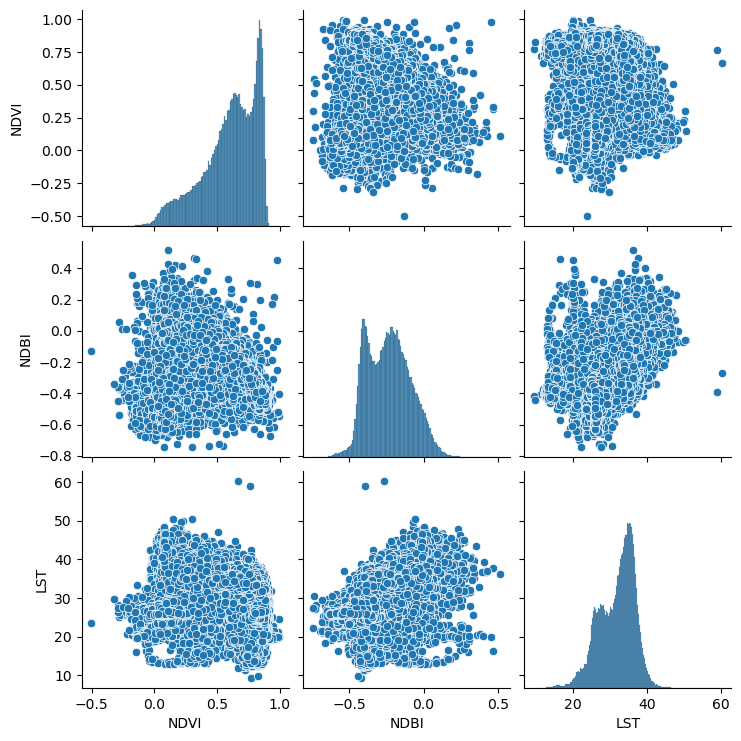

In [6]:
# Basic correlogram
sns.pairplot(combined_gdf[attributes])
# plt.savefig('output/berlin_corr_chart.png', dpi=300, bbox_inches='tight')

<Axes: >

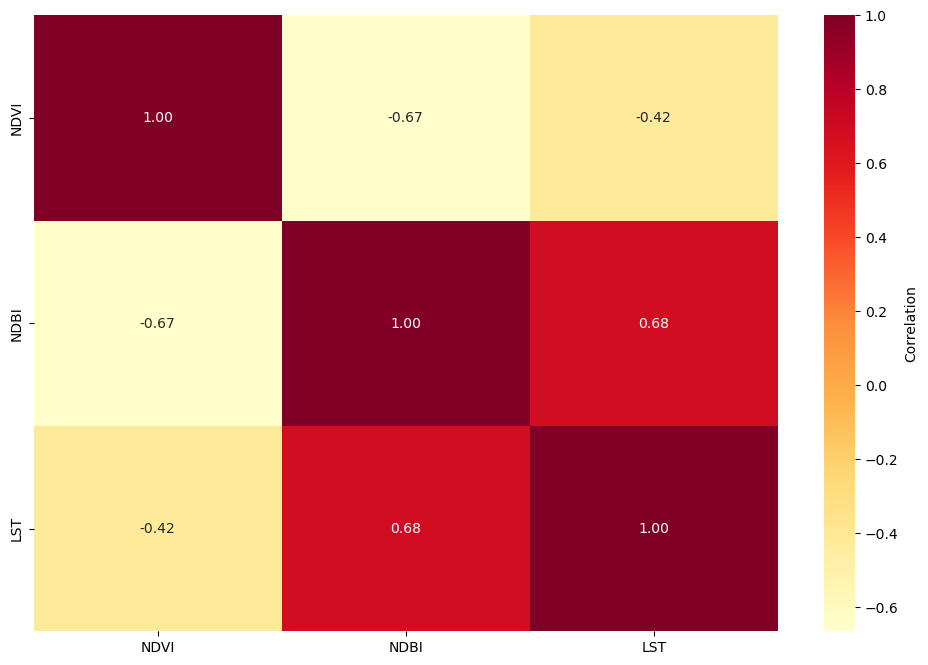

In [7]:
# Create publication-ready table visualization
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, 
            annot=True,  # Show values in cells
            fmt='.2f',   # Two decimal places
            cmap='YlOrRd',
            cbar_kws={'label': 'Correlation'},
            )
# plt.savefig('output/berlin_corr_heat.png', dpi=300, bbox_inches='tight')

In [8]:
# Save as high-resolution images
plt.savefig('output/berlin_corr_heat.png', dpi=300, bbox_inches='tight')
plt.savefig('output/berlin_corr_chart.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>